this is my first none mnist/tf dataset network. I had no goals but to have some fun and get something done. This dataset is avialable at: https://www.kaggle.com/gpiosenka/100-bird-species 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow.keras.regularizers as regularizers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from IPython.display import Image, display
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


get to know the data

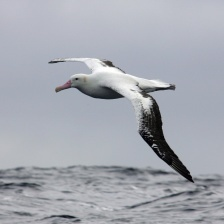

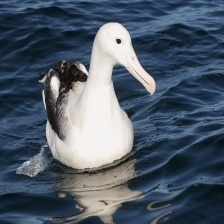

In [2]:
x = Image(filename='./285 birds/test/ALBATROSS/1.jpg') 
y = Image(filename='./285 birds/test/ALBATROSS/2.jpg') 
display(x, y)

images have some room on the sides so we will rotate/crop them 

In [2]:


batch_size = 256

train_datagen = ImageDataGenerator(
    rescale = 1./255., 
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    rescale = 1./255.)

train_gen = train_datagen.flow_from_directory(
        './285 birds/train',
        target_size=(122, 122),
        batch_size=batch_size,
        class_mode='categorical')

val_gen = val_datagen.flow_from_directory(
        './285 birds/valid',
        target_size=(122, 122),
        batch_size=batch_size,
        class_mode='categorical')

test_gen = test_datagen.flow_from_directory(
        './285 birds/test',
        target_size=(122, 122),
        batch_size=batch_size,
        class_mode='categorical')

Found 40930 images belonging to 285 classes.
Found 1425 images belonging to 285 classes.
Found 1425 images belonging to 285 classes.


In [12]:
tf.keras.backend.clear_session()

def scheduler(epoch, lr):
    return  1e-3 *10**(-epoch/20) +1e-4

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

input_shape = (122, 122, 3)

inputs = Input(shape = input_shape)
x = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(5e-4))(inputs)
x = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(5e-4))(x)
x = MaxPool2D()(x)
x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(5e-4))(x)
x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(5e-4))(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(1024, activation= 'relu', kernel_regularizer = regularizers.l2(1e-4))(x)
x = Dropout(.2)(x)
x = Dense(512, activation= 'relu')(x)
x = Dense(285, activation='softmax',  kernel_regularizer = regularizers.l2(1e-4))(x)


model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1 = .99),
              loss='categorical_crossentropy',
              metrics=['acc'],
              )
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 122, 122, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 122, 122, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0     

In [5]:
history = model.fit(train_gen,
                    validation_data = val_gen,
                    epochs=160,
                    callbacks=[callback],
                    verbose=1)
model.save_weights('./checkpoint_dir/epoch160')

Epoch 1/160
160/160 [==============================] - 168s 1s/step - loss: 5.2598 - acc: 0.0222 - val_loss: 4.6532 - val_acc: 0.0561
Epoch 2/160
160/160 [==============================] - 168s 1s/step - loss: 4.4813 - acc: 0.0818 - val_loss: 3.9420 - val_acc: 0.1354
Epoch 3/160
160/160 [==============================] - 171s 1s/step - loss: 3.9699 - acc: 0.1472 - val_loss: 3.4413 - val_acc: 0.2281
Epoch 4/160
160/160 [==============================] - 177s 1s/step - loss: 3.6102 - acc: 0.2022 - val_loss: 3.1528 - val_acc: 0.2639
Epoch 5/160
160/160 [==============================] - 171s 1s/step - loss: 3.3217 - acc: 0.2482 - val_loss: 2.8428 - val_acc: 0.3081
Epoch 6/160
160/160 [==============================] - 169s 1s/step - loss: 3.1042 - acc: 0.2883 - val_loss: 2.6630 - val_acc: 0.3593
Epoch 7/160
160/160 [==============================] - 164s 1s/step - loss: 2.9420 - acc: 0.3184 - val_loss: 2.4707 - val_acc: 0.4021
Epoch 8/160
160/160 [==============================] - 165s 1s

In [6]:
loss = history.history['loss']
acc = history.history['acc']
f, axs = plt.subplots(4, 1)
axs[0].plot(loss)
axs[1].plot(acc)
axs[2].plot(loss[80:])
axs[3].plot(acc[80:])

NameError: name 'history' is not defined

Accuracy and loss are both trending in a positive direction. Although there is some noise in loss, it is overwhelmed by a downward trend. to combat this I will have the learning rate approach to 3e-5 getting there around 40 epochs.

In [13]:
def scheduler(epoch, lr):
    return 1e-4

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.load_weights('./checkpoint_dir/epoch160')

history1 = model.fit(train_gen,
                    validation_data = val_gen,
                    epochs=20,
                    callbacks=[callback],
                    verbose=1)

model.save_weights('./checkpoint_dir/epoch180')

Epoch 1/20
160/160 [==============================] - 174s 1s/step - loss: 3.4962 - acc: 0.6828 - val_loss: 3.6431 - val_acc: 0.6667
Epoch 2/20
160/160 [==============================] - 176s 1s/step - loss: 3.3742 - acc: 0.6844 - val_loss: 3.5763 - val_acc: 0.6653
Epoch 3/20
160/160 [==============================] - 173s 1s/step - loss: 3.2759 - acc: 0.6835 - val_loss: 3.4385 - val_acc: 0.6863
Epoch 4/20
160/160 [==============================] - 177s 1s/step - loss: 3.1900 - acc: 0.6841 - val_loss: 3.3117 - val_acc: 0.6765
Epoch 5/20
160/160 [==============================] - 175s 1s/step - loss: 3.1144 - acc: 0.6829 - val_loss: 3.2633 - val_acc: 0.6807
Epoch 6/20
160/160 [==============================] - 176s 1s/step - loss: 3.0246 - acc: 0.6845 - val_loss: 3.1256 - val_acc: 0.6863
Epoch 7/20
160/160 [==============================] - 180s 1s/step - loss: 2.9693 - acc: 0.6823 - val_loss: 3.1116 - val_acc: 0.6912
Epoch 8/20
160/160 [==============================] - 177s 1s/step - 

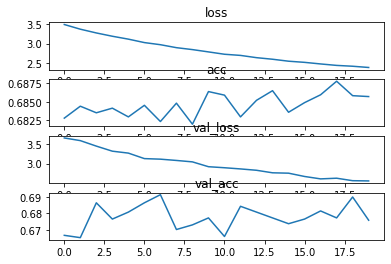

In [17]:
f, axs = plt.subplots(4, 1)
for ax, key in zip(axs, history1.history):
    ax.plot(history1.history[key])
    ax.set_title(key)

In [19]:
test_eval = model.evaluate(test_gen)
train_eval = model.evaluate(train_gen)
val_eval = model.evaluate(val_gen)
print("eval train: ", train_eval)
print("eval val: ", val_eval)
print("eval test: ", test_eval)

6/6 [==============================] - 6s 958ms/step - loss: 2.5569 - acc: 0.6702
eval train:  [2.081049919128418, 0.7677498459815979]
eval val:  [2.5568814277648926, 0.6701754331588745]
eval test:  [2.5568814277648926, 0.6701754331588745]


loss is still decreasing with stability, that is good. val_loss is also fairly stable, val_acc seems to be trending upwards but it is hard to say. lets deincremient the step size by 1/2 this should allow the model to go down in a more precise manor

there does appear to be some significant overfitting, to combat this lets try adding very light l2 to the second to last dense layer in an attempt to punish any outlying wieghts. 


In [5]:
tf.keras.backend.clear_session()

input_shape = (122, 122, 3)

inputs = Input(shape = input_shape)
x = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(5e-4))(inputs)
x = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(5e-4))(x)
x = MaxPool2D()(x)
x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(5e-4))(x)
x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(5e-4))(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(1024, activation= 'relu', kernel_regularizer = regularizers.l2(1e-4))(x)
x = Dropout(.2)(x)
x = Dense(512, activation= 'relu', kernel_regularizer = regularizers.l2(5e-5))(x)
x = Dense(285, activation='softmax',  kernel_regularizer = regularizers.l2(1e-4))(x)


model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1 = .99),
              loss='categorical_crossentropy',
              metrics=['acc'],
              )
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 122, 122, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 122, 122, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0     

In [8]:
def scheduler(epoch, lr):
    return 1e-5

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.load_weights('./checkpoint_dir/epoch180')

history2 = model.fit(train_gen,
                    validation_data = val_gen,
                    epochs=10,
                    callbacks=[callback],
                    verbose=1)

model.save_weights('./checkpoint_dir/epoch190')

Epoch 1/10
160/160 [==============================] - 177s 1s/step - loss: 2.3917 - acc: 0.6946 - val_loss: 2.6089 - val_acc: 0.6821
Epoch 2/10
160/160 [==============================] - 194s 1s/step - loss: 2.3772 - acc: 0.6987 - val_loss: 2.5952 - val_acc: 0.6891
Epoch 3/10
160/160 [==============================] - 187s 1s/step - loss: 2.3668 - acc: 0.6998 - val_loss: 2.6308 - val_acc: 0.6849
Epoch 4/10
160/160 [==============================] - 163s 1s/step - loss: 2.3572 - acc: 0.6976 - val_loss: 2.5705 - val_acc: 0.6982
Epoch 5/10
160/160 [==============================] - 172s 1s/step - loss: 2.3574 - acc: 0.6984 - val_loss: 2.6041 - val_acc: 0.6737
Epoch 6/10
160/160 [==============================] - 178s 1s/step - loss: 2.3464 - acc: 0.7028 - val_loss: 2.5823 - val_acc: 0.6800
Epoch 7/10
160/160 [==============================] - 174s 1s/step - loss: 2.3432 - acc: 0.7042 - val_loss: 2.5772 - val_acc: 0.6996
Epoch 8/10
160/160 [==============================] - 172s 1s/step - 

In [9]:
test_eval = model.evaluate(test_gen)
train_eval = model.evaluate(train_gen)
val_eval = model.evaluate(val_gen)
print("eval train: ", train_eval)
print("eval val: ", val_eval)
print("eval test: ", test_eval)

6/6 [==============================] - 6s 1s/step - loss: 2.5489 - acc: 0.6856
eval train:  [2.0741851329803467, 0.7803811430931091]
eval val:  [2.548884153366089, 0.6856140494346619]
eval test:  [2.5719289779663086, 0.6849122643470764]


this network is doing ok, I think I could easily make a better one. I'm going to move onto a better network archecture that has more Conv2d/maxpool layers to decrease the size of the initial dense. 

As of now I need to get a better intuition for hyperparams and learn to use grid/random search then move onto bayesian opt

Some final thoughts 

 - this actually preformed ok, 70% on 285 classes is not bad 
 - dont have super large dense layers :/
 - transfer learning saves time lol, but it is fun to make your own networks 
 